# Text to SQL on multi-tables database


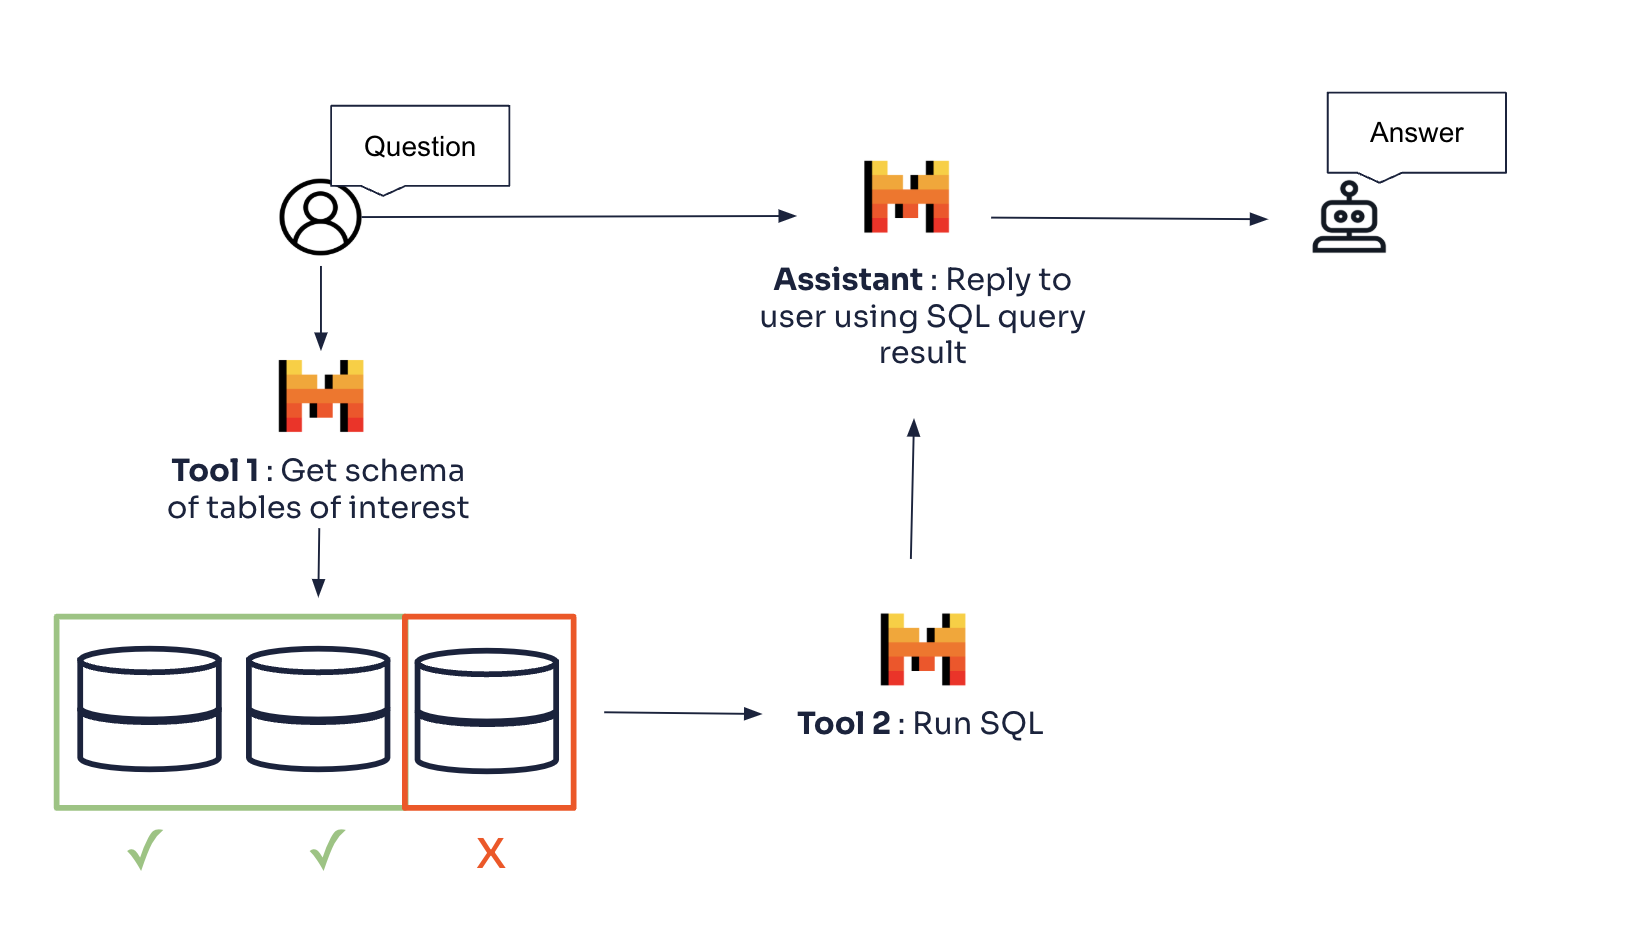

In this cookbook we will show you how to : 

- Use the function calling capabilities of Mistral models 
- Build a text2SQL architecture that scales more efficiently than a naive approach where all schemas are integrally injected in the system prompt  
- Evaluate your system with Mistral models and leveraging the DeepEval framework 

# Imports

In [ ]:
!pip install mistralai langchain deepeval

In [82]:
from mistralai import Mistral
from getpass import getpass

# To interract with the SQL database 
from langchain_community.utilities import SQLDatabase

# To evaluate text2SQL performances 
from deepeval.models import DeepEvalBaseLLM
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.dataset import EvaluationDataset
from deepeval.metrics import GEval

# Load the Chinook database 

"Chinook is a sample database available for SQL Server, Oracle, MySQL, etc. It can be created by running a single SQL script. Chinook database is an alternative to the Northwind database, being ideal for demos and testing ORM tools targeting single and multiple database servers."

To run this notebook you will need to download the Chinook datase. You will find more information about this database by clicking on this [github link](https://github.com/lerocha/chinook-database). 

To create the `Chinook.db` in the same directory as this notebook you have several options : 

- You can download and build the database via the command line :
 
```
curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
```

- Another strategy consists in using running the following script `https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql`. 

First save the script to a folder/directory on your compute. Then create a database called Chinook `sqlite3 Chinook.db` and ultimately run the script with `.read Chinook_Sqlite.sql`

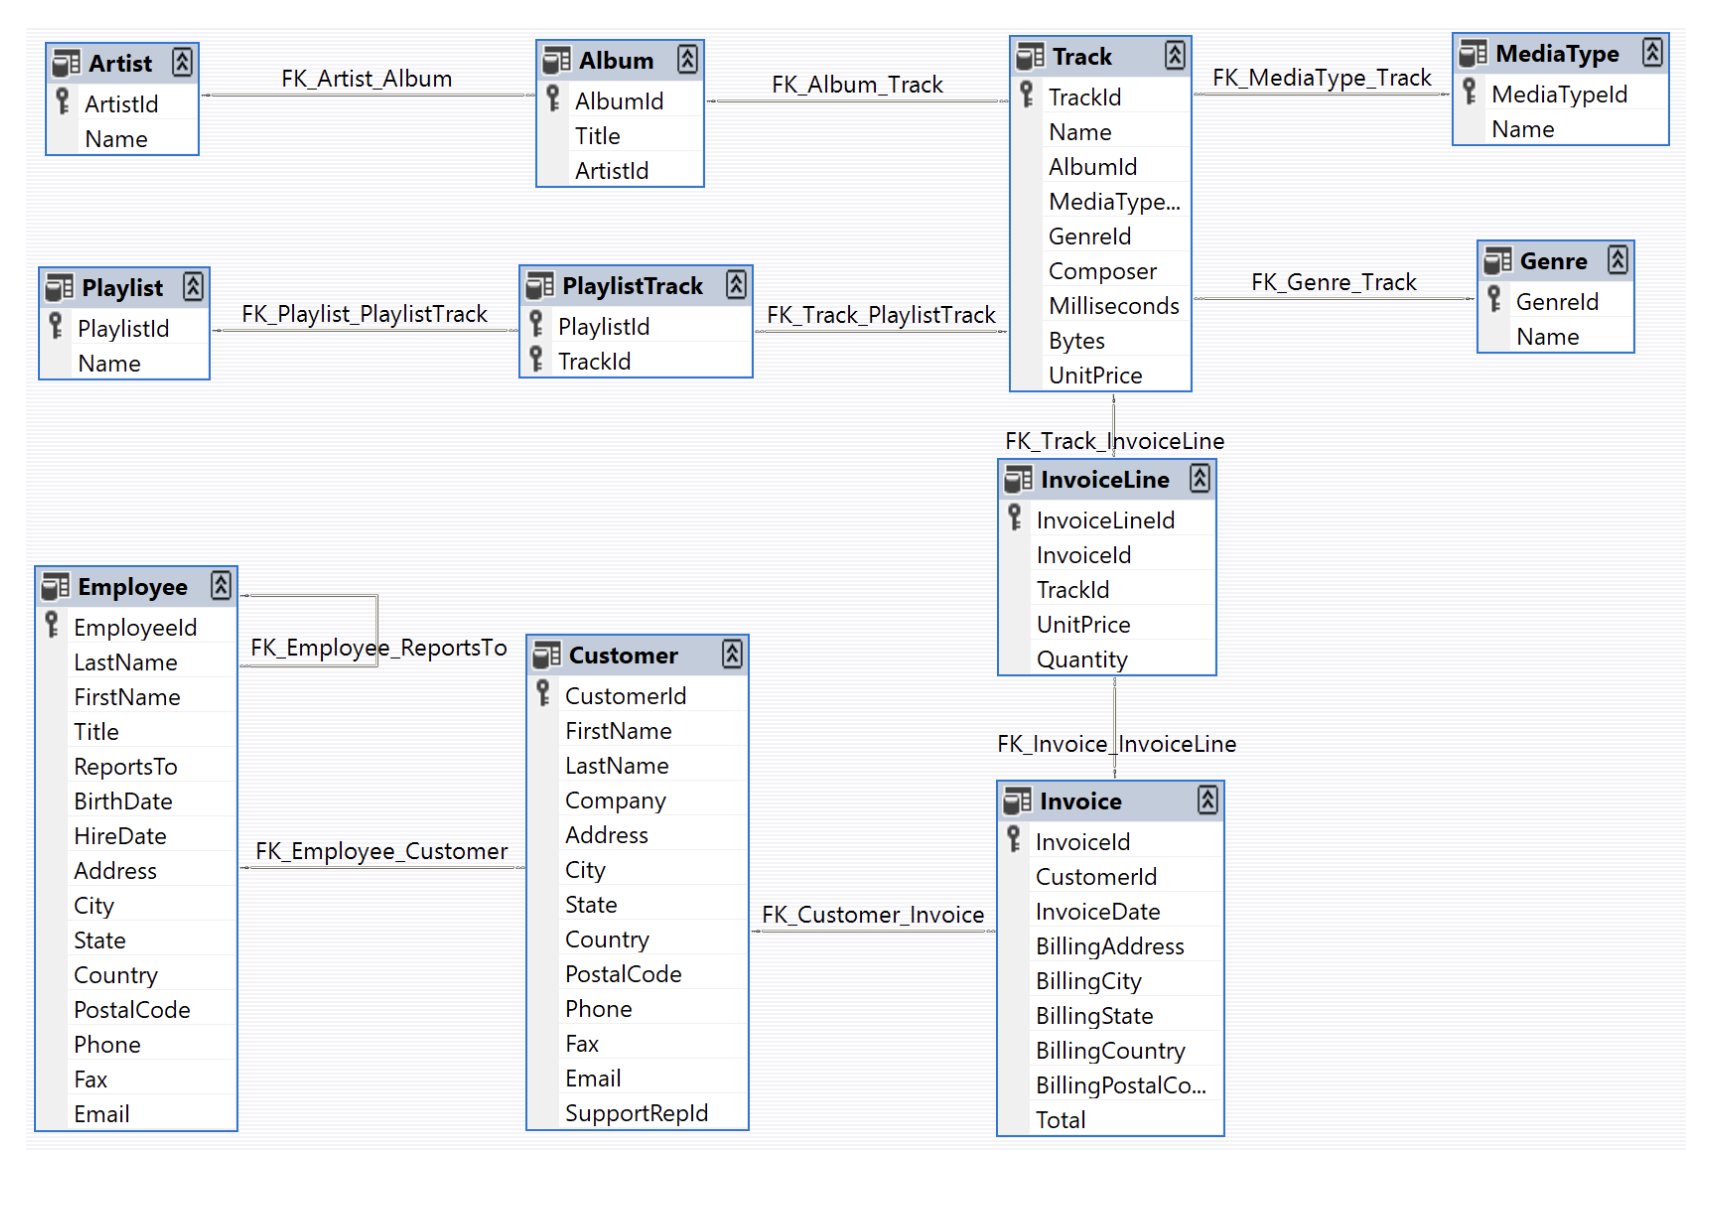

 # Set up clients

In [83]:
api_key= getpass("Type your API Key")
client = Mistral(api_key=api_key)
uri = getpass("Type your SQLDatabase uri")

# Interract with the Chinook database

We are defining two functions : 
- run_sql_query that runs sql code on Chinook
- get_sql_schema_of_table that returns the schema of a table specified as input 

In [84]:
def run_sql_query(sql_code):
    """
    Executes the given SQL query against the database and returns the results.

    Args:
        sql_code (str): The SQL query to be executed.

    Returns:
        result: The results of the SQL query.
    """
    db = SQLDatabase.from_uri(uri)
    return db.run(sql_code)

db.run("SELECT * FROM Artist LIMIT 10;")

"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [85]:
def get_sql_schema_of_table(table):
    """
    Returns the schema of a table.

    Args:
        table (str): Name of the table to be described

    Returns:
        result: Column names and types of the table
    """
    if table == "Album":
        return """ The table Album was created with the following code : 

CREATE TABLE [Album]
(
    [AlbumId] INTEGER  NOT NULL,
    [Title] NVARCHAR(160)  NOT NULL,
    [ArtistId] INTEGER  NOT NULL,
    CONSTRAINT [PK_Album] PRIMARY KEY  ([AlbumId]),
    FOREIGN KEY ([ArtistId]) REFERENCES [Artist] ([ArtistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);     
        """

    if table == "Artist":
        return """ The table Artist was created with the following code : 
        
CREATE TABLE [Artist]
(
    [ArtistId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_Artist] PRIMARY KEY  ([ArtistId])
);    
        """

    if table == "Customer":
        return """ The table Customer was created with the following code : 

CREATE TABLE [Customer]
(
    [CustomerId] INTEGER  NOT NULL,
    [FirstName] NVARCHAR(40)  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [Company] NVARCHAR(80),
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60)  NOT NULL,
    [SupportRepId] INTEGER,
    CONSTRAINT [PK_Customer] PRIMARY KEY  ([CustomerId]),
    FOREIGN KEY ([SupportRepId]) REFERENCES [Employee] ([EmployeeId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);             
        """

    if table == "Employee":
        return """ The table Employee was created with the following code : 

CREATE TABLE [Employee]
(
    [EmployeeId] INTEGER  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [FirstName] NVARCHAR(20)  NOT NULL,
    [Title] NVARCHAR(30),
    [ReportsTo] INTEGER,
    [BirthDate] DATETIME,
    [HireDate] DATETIME,
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60),
    CONSTRAINT [PK_Employee] PRIMARY KEY  ([EmployeeId]),
    FOREIGN KEY ([ReportsTo]) REFERENCES [Employee] ([EmployeeId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);            
        """

    if table == "Genre":
        return """ The table Genre was created with the following code : 
        
 CREATE TABLE [Genre]
(
    [GenreId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_Genre] PRIMARY KEY  ([GenreId])
);             
        """

    if table == "Invoice":
        return """ The table Invoice was created with the following code : 

CREATE TABLE [Invoice]
(
    [InvoiceId] INTEGER  NOT NULL,
    [CustomerId] INTEGER  NOT NULL,
    [InvoiceDate] DATETIME  NOT NULL,
    [BillingAddress] NVARCHAR(70),
    [BillingCity] NVARCHAR(40),
    [BillingState] NVARCHAR(40),
    [BillingCountry] NVARCHAR(40),
    [BillingPostalCode] NVARCHAR(10),
    [Total] NUMERIC(10,2)  NOT NULL,
    CONSTRAINT [PK_Invoice] PRIMARY KEY  ([InvoiceId]),
    FOREIGN KEY ([CustomerId]) REFERENCES [Customer] ([CustomerId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);            
        """

    if table == "InvoiceLine":
        return """ The table InvoiceLine was created with the following code : 

CREATE TABLE [InvoiceLine]
(
    [InvoiceLineId] INTEGER  NOT NULL,
    [InvoiceId] INTEGER  NOT NULL,
    [TrackId] INTEGER  NOT NULL,
    [UnitPrice] NUMERIC(10,2)  NOT NULL,
    [Quantity] INTEGER  NOT NULL,
    CONSTRAINT [PK_InvoiceLine] PRIMARY KEY  ([InvoiceLineId]),
    FOREIGN KEY ([InvoiceId]) REFERENCES [Invoice] ([InvoiceId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([TrackId]) REFERENCES [Track] ([TrackId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);              
        """


    if table == "MediaType":
        return """ The table MediaType was created with the following code : 

CREATE TABLE [MediaType]
(
    [MediaTypeId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_MediaType] PRIMARY KEY  ([MediaTypeId])
);           
        """

    if table == "Playlist":
        return """ The table Playlist was created with the following code : 

CREATE TABLE [Playlist]
(
    [PlaylistId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_Playlist] PRIMARY KEY  ([PlaylistId])
);       
        """

    if table == "PlaylistTrack":
        return """ The table PlaylistTrack was created with the following code : 

CREATE TABLE [PlaylistTrack]
(
    [PlaylistId] INTEGER  NOT NULL,
    [TrackId] INTEGER  NOT NULL,
    CONSTRAINT [PK_PlaylistTrack] PRIMARY KEY  ([PlaylistId], [TrackId]),
    FOREIGN KEY ([PlaylistId]) REFERENCES [Playlist] ([PlaylistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([TrackId]) REFERENCES [Track] ([TrackId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);         
        """

    if table == "Track":
        return """ The table Track was created with the following code : 

CREATE TABLE [Track]
(
    [TrackId] INTEGER  NOT NULL,
    [Name] NVARCHAR(200)  NOT NULL,
    [AlbumId] INTEGER,
    [MediaTypeId] INTEGER  NOT NULL,
    [GenreId] INTEGER,
    [Composer] NVARCHAR(220),
    [Milliseconds] INTEGER  NOT NULL,
    [Bytes] INTEGER,
    [UnitPrice] NUMERIC(10,2)  NOT NULL,
    CONSTRAINT [PK_Track] PRIMARY KEY  ([TrackId]),
    FOREIGN KEY ([AlbumId]) REFERENCES [Album] ([AlbumId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([GenreId]) REFERENCES [Genre] ([GenreId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([MediaTypeId]) REFERENCES [MediaType] ([MediaTypeId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);         
        """

    return f"The table {table} does not exist in the Chinook database"

# Build agent 

In [87]:
def get_response(question, verbose=True):
    """
    Answer question about the Chinook database.

    Args:
        question (str): The question asked by the user.
        verbose (bool): If True, prints intermediate steps and results.

    Returns:
        str: The response to the user's question.
    """

    # Define the tools available for the AI assistant
    tools = [
        {
            "type": "function",
            "function": {
                "name": "get_sql_schema_of_table",
                "description": "Get the schema of a table in the Chinook database",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "table": {
                            "type": "string",
                            "enum": ["Album", "Artist", "Customer", "Employee", "Genre", "Invoice", "InvoiceLine", "MediaType", "Playlist", "PlaylistTrack", "Track"],
                            "description": "The question asked by the user",
                        },
                    },
                    "required": ["table"],
                },
            },
        },
        {
            "type": "function",
            "function": {
                "name": "run_sql_query",
                "description": "Run an SQL query on the Chinook database",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "sql_code": {
                            "type": "string",
                            "description": "SQL code to be run",
                        },
                    },
                    "required": ["sql_code"],
                },
            },
        }
    ]

    # System prompt for the AI assistant
    system_prompt = """
    You are an AI assistant.
    Your job is to reply to questions related to the Chinook database.
    The Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices, and customers.

    To answer user questions, you have two tools at your disposal.

    Firstly, a function called "get_sql_schema_of_table" which has a single parameter named "table" whose value is an element
    of the following list: ["Album", "Artist", "Customer", "Employee", "Genre", "Invoice", "InvoiceLine", "MediaType", "Playlist", "PlaylistTrack", "Track"].

    Secondly, a function called "run_sql_query" which has a single parameter named "sql_code".
    It will run SQL code on the Chinook database. The SQL dialect is SQLite.

    For a given question, your job is to:
    1. Get the schemas of the tables that might help you answer the question using the "get_sql_schema_of_table" function.
    2. Run a SQLite query on the relevant tables using the "run_sql_query" function.
    3. Answer the user based on the result of the SQL query.

    You will always remain factual, you will not hallucinate, and you will say that you don't know if you don't know.
    You will politely ask the user to shoot another question if the question is not related to the Chinook database.
    """

    # Initialize chat history with system prompt and user question
    chat_history = [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": question
        }
    ]

    if verbose:
        print(f"User: {question}\n")

    used_run_sql = False
    used_get_sql_schema_of_table = False

    # Function to determine tool choice based on usage
    def tool_choice(used_run_sql, used_get_sql_schema_of_table):
        # If the question is out of topic the agent is not expected to run a tool call 
        if not used_get_sql_schema_of_table:
            return "auto"
        # The agent is expected to run "used_run_sql" after getting the specifications of the tables of interest
        if used_get_sql_schema_of_table and not used_run_sql:
            return "any"
        # The agent is not expected to run a tool call after querying the SQL table
        if used_run_sql and used_get_sql_schema_of_table:
            return "none"
        return "auto"

    iteration = 0
    max_iteration = 10

    # Main loop to process the question
    while iteration < max_iteration:
        inference = client.chat.complete(
            model="mistral-large-latest",
            temperature=0.3,
            messages=chat_history,
            tools=tools,
            tool_choice=tool_choice(used_run_sql, used_get_sql_schema_of_table)
        )

        chat_history.append(inference.choices[0].message)

        tool_calls = inference.choices[0].message.tool_calls

        if not tool_calls:
            if verbose:
                print(f"Assistant: {inference.choices[0].message.content}\n")
            return inference.choices[0].message.content

        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_params = json.loads(tool_call.function.arguments)

            if function_name == "get_sql_schema_of_table":
                function_result = get_sql_schema_of_table(function_params['table'])
                if verbose:
                    print(f"Tool: Getting SQL schema of table {function_params['table']}\n")
                used_get_sql_schema_of_table = True

            if function_name == "run_sql_query":
                function_result = run_sql_query(function_params['sql_code'])
                if verbose:
                    print(f"Tool: Running code {function_params['sql_code']}\n")
                used_run_sql = True

            chat_history.append({"role": "tool", "name": function_name, "content": function_result, "tool_call_id": tool_call.id})

        iteration += 1
    return

# Test the agent 

Let's test the agent and ask a few random questions of increasing complexity

In [89]:
# Lets start by checking how the model reacts with out of topic questions !
response = get_response('What is the oldest player in the NBA ?')

User: What is the oldest player in the NBA ?

Assistant: I'm sorry, but I can only answer questions related to the Chinook database, which is a digital media store. I can't answer questions about the NBA. Please ask another question.



In [90]:
response = get_response('What are the genre in the store ?')

User: What are the genre in the store ?

Tool: Getting SQL schema of table Genre

Tool: Running code SELECT Name FROM Genre;

Assistant: Here are the genres available in the store:

1. Rock
2. Jazz
3. Metal
4. Alternative & Punk
5. Rock And Roll
6. Blues
7. Latin
8. Reggae
9. Pop
10. Soundtrack
11. Bossa Nova
12. Easy Listening
13. Heavy Metal
14. R&B/Soul
15. Electronica/Dance
16. World
17. Hip Hop/Rap
18. Science Fiction
19. TV Shows
20. Sci Fi & Fantasy
21. Drama
22. Comedy
23. Alternative
24. Classical
25. Opera



In [91]:
response = get_response('What are the albums of the rock band U2 ?')

User: What are the albums of the rock band U2 ?

Tool: Getting SQL schema of table Album

Tool: Getting SQL schema of table Artist

Tool: Running code SELECT Title FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'U2')

Assistant: The albums of the rock band U2 are :

1. Achtung Baby
2. All That You Can't Leave Behind
3. B-Sides 1980-1990
4. How To Dismantle An Atomic Bomb
5. Pop
6. Rattle And Hum
7. The Best Of 1980-1990
8. War
9. Zooropa
10. Instant Karma: The Amnesty International Campaign to Save Darfur



In [92]:
response = get_response('What is the shortest song that the rock band U2 ever composed ?')

User: What is the shortest song that the rock band U2 ever composed ?

Tool: Getting SQL schema of table Artist

Tool: Getting SQL schema of table Album

Tool: Getting SQL schema of table Track

Tool: Running code SELECT Name, Milliseconds FROM Track WHERE Milliseconds = (SELECT MIN(Milliseconds) FROM Track WHERE Composer = 'U2') AND Composer = 'U2';

Assistant: The shortest song that the rock band U2 ever composed is "Trash, Trampoline And The Party Girl" with a duration of 2 minutes and 34 seconds.



In [93]:
response = get_response('Which track from U2 is the most sold ?')

User: Which track from U2 is the most sold ?

Tool: Getting SQL schema of table Track

Tool: Getting SQL schema of table Artist

Tool: Getting SQL schema of table InvoiceLine

Tool: Running code SELECT Track.Name, SUM(InvoiceLine.Quantity) as TotalSold    FROM Track    JOIN InvoiceLine ON Track.TrackId = InvoiceLine.TrackId    JOIN Album ON Track.AlbumId = Album.AlbumId    JOIN Artist ON Album.ArtistId = Artist.ArtistId    WHERE Artist.Name = 'U2'    GROUP BY Track.Name    ORDER BY TotalSold DESC    LIMIT 1;

Assistant: The most sold track from U2 is "Sweetest Thing" with 3 copies sold.



In [94]:
response = get_response('Which consumer bought the biggest amound of U2 songs ?')

User: Which consumer bought the biggest amound of U2 songs ?

Tool: Getting SQL schema of table Track

Tool: Getting SQL schema of table InvoiceLine

Tool: Getting SQL schema of table Invoice

Tool: Getting SQL schema of table Customer

Tool: Running code WITH U2_Songs AS (
    SELECT TrackId
    FROM Track
    WHERE Composer = 'U2'
)

SELECT Customer.CustomerId, Customer.FirstName, Customer.LastName, SUM(InvoiceLine.Quantity) as total_quantity
FROM InvoiceLine
JOIN Invoice ON InvoiceLine.InvoiceId = Invoice.InvoiceId
JOIN Customer ON Invoice.CustomerId = Customer.CustomerId
JOIN U2_Songs ON InvoiceLine.TrackId = U2_Songs.TrackId
GROUP BY Customer.CustomerId
ORDER BY total_quantity DESC
LIMIT 1;

Assistant: The consumer who bought the biggest amount of U2 songs is Richard Cunningham. He bought 5 songs.



In [100]:
response = get_response('List all artist that have a color in their name')

User: List all artist that have a color in their name

Tool: Getting SQL schema of table Artist

Tool: Running code SELECT Name FROM Artist WHERE Name LIKE '%Red%' OR Name LIKE '%Blue%' OR Name LIKE '%Green%' OR Name LIKE '%Yellow%' OR Name LIKE '%Black%' OR Name LIKE '%White%' OR Name LIKE '%Pink%' OR Name LIKE '%Purple%' OR Name LIKE '%Orange%' OR Name LIKE '%Brown%' OR Name LIKE '%Grey%' OR Name LIKE '%Gray%';

Assistant: Here is the list of artists that have a color in their name:

1. Black Label Society
2. Black Sabbath
3. Pedro Luís & A Parede
4. Banda Black Rio
5. Green Day
6. Deep Purple
7. James Brown
8. Pink Floyd
9. Red Hot Chili Peppers
10. Simply Red
11. The Black Crowes
12. Whitesnake
13. Jackson Browne
14. Black Eyed Peas
15. Charlie Brown Jr.
16. Pedro Luís E A Parede



In [95]:
response = get_response('Who are our top Customers according to Invoices?')

User: Who are our top Customers according to Invoices?

Tool: Getting SQL schema of table Customer

Tool: Getting SQL schema of table Invoice

Tool: Running code SELECT Customer.CustomerId, Customer.FirstName, Customer.LastName, SUM(Invoice.Total) as TotalSpent FROM Customer JOIN Invoice ON Customer.CustomerId = Invoice.CustomerId GROUP BY Customer.CustomerId ORDER BY TotalSpent DESC LIMIT 10;

Assistant: Here are the top customers according to invoices:

1. Helena Holý: 49.62
2. Richard Cunningham: 47.62
3. Luis Rojas: 46.62
4. Ladislav Kovács: 45.62
5. Hugh O'Reilly: 45.62
6. Frank Ralston: 43.62
7. Julia Barnett: 43.62
8. Fynn Zimmermann: 43.62
9. Astrid Gruber: 42.62
10. Victor Stevens: 42.62



# Evaluating 

Let's try to evaluate the agent in a more formal way. 

We will build a test set based on the questions from this Medium article [Chinook question/answers](https://medium.com/@raufrukayat/chinook-database-querying-a-digital-music-store-database-8c98cf0f8611)

We will evaluate answers via LLM as a judge through the framework [DeepEval](https://docs.confident-ai.com/) from which the image here below is taken.

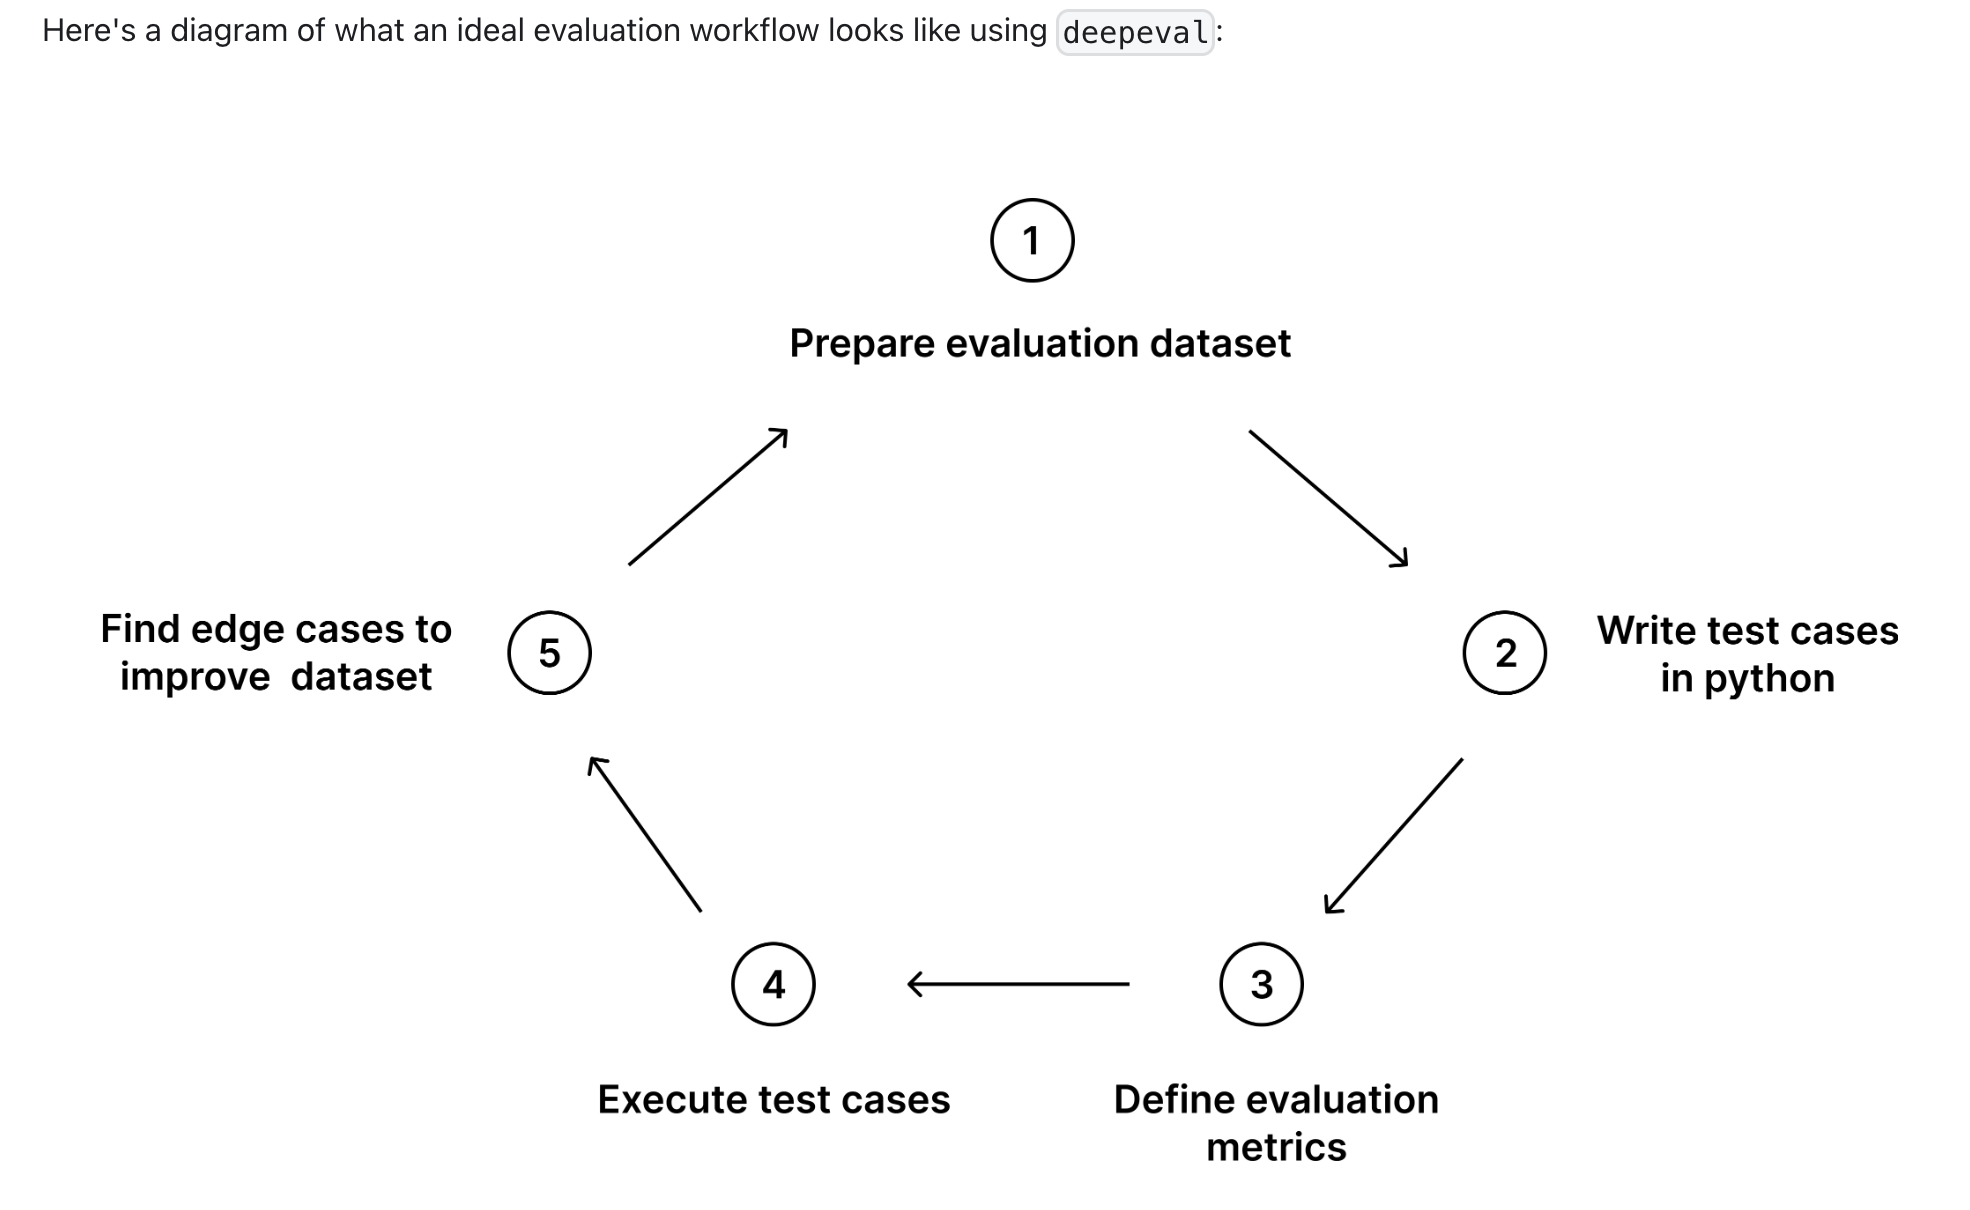

In [102]:
class CustomMistralLarge(DeepEvalBaseLLM):
    def __init__(self, api_key):
        self.client = Mistral(api_key=api_key)
        self.model_name = "mistral-large-latest"

    def get_model_name(self):
        return "Mistral-large-latest"

    def load_model(self):
        # Since we are using the Mistral API, we don't need to load a model object.
        return self.client

    def generate(self, prompt: str) -> str:
        chat_response = self.client.chat.complete(
            model=self.model_name,
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                },
            ]
        )
        return chat_response.choices[0].message.content

    async def a_generate(self, prompt: str) -> str:
        # Reusing the synchronous generate method for simplicity.
        return self.generate(prompt)

In [103]:
# Specify questions
questions = [
    "Which Employee has the Highest Total Number of Customers?",
    "Who are our top Customers according to Invoices?",
    "How many Rock music listeners are there ?",
    "What artists have written most rock music songs ?",
    "Which artist has earned the most according to the Invoice Lines? How much is it ?",
    "How many tracks have a song length greater than the average song length ?",
    "What is the most popular genre for Australia ?"
]

# Specify associated answers
golden_answers = [
    "Peacock Jane has the most customers (she has 21 customers)",
    "Helena Holy, Richard Cunningham, Luis Rojas, Ladislav Kovacs, and Hugh O’Reilly are the top five customers who have spent the highest amount of money according to the invoice",
    "We found out that all 59 customers in the database have listened to Rock Music.",
    "Led Zeppelin tops the list of Artists who have written the most Rock Music with 114 songs followed Closely by U2 with 112 music.",
    "The Artist who has earned the most according to the invoice lines is Iron Maiden with a total of $138.6.",
    "Out of 3503 songs in the database, we found out that 494 of these songs have length more than the average music length of 393,599.21 milliseconds.",
    "Rock is the most popular song for Australia"
    
]

# Build evaluation dataset
test_cases = [
    LLMTestCase(
        input=question, 
        actual_output=get_response(question, verbose=False),
        expected_output=golden
    ) for question, golden in zip(questions, golden_answers)
]
dataset = EvaluationDataset(test_cases=test_cases)

# Specify evaluation metric 
correctness_metric = GEval(
    name="Correctness",
    criteria="Determine whether the actual output is factually correct based on the expected output.",
    # NOTE: you can only provide either criteria or evaluation_steps, and not both
    evaluation_steps=[
        "Check whether the facts in 'actual output' contradicts any facts in 'expected output",
        "You should also heavily penalize situations where the actual output does not answers the question",
    ],
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT],
    model=CustomMistralLarge(api_key)
)

# Evaluate agent 
dataset.evaluate([correctness_metric])

✨ You're running DeepEval's latest Correctness (GEval) Metric! (using Mistral-large-latest, strict=False, 
async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 7 test case(s) in parallel: |█|100% (7/7) [Time Taken: 00:13,  1.88s/



Metrics Summary

  - ✅ Correctness (GEval) (score: 0.9, threshold: 0.5, strict: False, evaluation model: Mistral-large-latest, reason: The actual output correctly identifies Jane Peacock as the employee with the highest number of customers and specifies the number as 21, which matches the expected output. However, it does not use the exact phrasing 'Peacock Jane has the most customers'., error: None)

For test case:

  - input: Which Employee has the Highest Total Number of Customers?
  - actual output: The employee with the highest total number of customers is Jane Peacock with 21 customers.
  - expected output: Peacock Jane has the most customers (she has 21 customers)
  - context: None
  - retrieval context: None


Metrics Summary

  - ✅ Correctness (GEval) (score: 0.6, threshold: 0.5, strict: False, evaluation model: Mistral-large-latest, reason: The actual output lists the top ten customers while the expected output only lists the top five. However, the actual output does answer

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

EvaluationResult(test_results=[TestResult(name='test_case_0', success=True, metrics_data=[MetricData(name='Correctness (GEval)', threshold=0.5, success=True, score=0.9, reason="The actual output correctly identifies Jane Peacock as the employee with the highest number of customers and specifies the number as 21, which matches the expected output. However, it does not use the exact phrasing 'Peacock Jane has the most customers'.", strict_mode=False, evaluation_model='Mistral-large-latest', error=None, evaluation_cost=None, verbose_logs='Criteria:\nDetermine whether the actual output is factually correct based on the expected output. \n \nEvaluation Steps:\n[\n    "Check whether the facts in \'actual output\' contradicts any facts in \'expected output",\n    "You should also heavily penalize situations where the actual output does not answers the question"\n]')], conversational=False, multimodal=False, input='Which Employee has the Highest Total Number of Customers?', actual_output='The 